In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import time

In [28]:
#pre-processing
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform) 
mean = dataset.data.mean(axis=(0,1,2))
std = dataset.data.std(axis=(0,1,2))
mean = mean / 255
std = std / 255

Files already downloaded and verified


In [29]:
mean, std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [30]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
     transforms.RandomAffine(10),
    transforms.Normalize(mean, std)])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean, std)])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [31]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


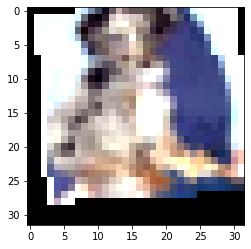

In [32]:
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images[4]))


In [33]:
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[4]]))

    d o g


In [34]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

#Model description
AlexNet_model.eval()

Using cache found in /home/heitz/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [35]:
AlexNet_model.features = nn.Sequential(
    AlexNet_model.features[0],nn.BatchNorm2d(96),AlexNet_model.features[1],AlexNet_model.features[2],AlexNet_model.features[3],
    nn.BatchNorm2d(256),AlexNet_model.features[4],AlexNet_model.features[5],AlexNet_model.features[6],
    nn.BatchNorm2d(384),AlexNet_model.features[7],AlexNet_model.features[8],
    nn.BatchNorm2d(384),AlexNet_model.features[9],AlexNet_model.features[10],
    nn.BatchNorm2d(256),AlexNet_model.features[11],AlexNet_model.features[12]
)

In [36]:
AlexNet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

In [37]:
#CV layer
AlexNet_model.features[0] = nn.Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
AlexNet_model.features[3] = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
AlexNet_model.features[4] = nn.Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
AlexNet_model.features[7] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
AlexNet_model.features[8] = nn.Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
AlexNet_model.features[11] = nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
AlexNet_model.features[14] = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
AlexNet_model.features[17] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#output
AlexNet_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

#Updating the second classifier
AlexNet_model.classifier[1] = nn.Linear(12544,4096)

#Updating the second classifier
AlexNet_model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[6] = nn.Linear(1024,10)


In [38]:
#Instantiating CUDA device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Weight initializing
#AlexNet_model.apply(weight_init)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cuda:1


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(3

In [39]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [40]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
#optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr = 0.0005, weight_decay=0.0001)
start = time.time()

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
         
    #Testing Accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(testloader,0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = AlexNet_model(images)
            loss = criterion(outputs, labels)
            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()
            # print statistics
            running_loss += loss.item()

    test_loss = running_loss/i
    test_acc = 100 * correct_test / total_test
                    
                    
    #Training Accuracy
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        running_loss=0.0
        for j,data in enumerate(trainloader,0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = AlexNet_model(images)
            loss = criterion(outputs, labels)
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            running_loss += loss.item()
            
    train_loss = running_loss /j
    train_acc = 100 * correct_train / total_train
    
    if abs(train_acc-test_acc)<=10:
        print("epoch:%d train_acc:%0.2f test_acc:%0.2f" % (epoch+1,train_acc, test_acc))
        print("epoch:%d train_loss:%0.2f test_loss:%0.2f" % (epoch+1,train_loss, test_loss))
    else:
        print("Overfitting!", train_acc, test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print("time: {}".format(time.time()-start))
print('Finished Training of AlexNet')

[1,   100] loss: 2.265
[1,   200] loss: 1.683
[1,   300] loss: 1.503
epoch:1 train_acc:50.50 test_acc:53.37
epoch:1 train_loss:1.35 test_loss:1.29
time: 93.4898989200592
[2,   100] loss: 1.321
[2,   200] loss: 1.256
[2,   300] loss: 1.164
epoch:2 train_acc:60.78 test_acc:62.08
epoch:2 train_loss:1.10 test_loss:1.07
time: 186.22208786010742
[3,   100] loss: 1.080
[3,   200] loss: 1.040
[3,   300] loss: 1.004
epoch:3 train_acc:66.16 test_acc:67.13
epoch:3 train_loss:0.94 test_loss:0.94
time: 279.9915256500244
[4,   100] loss: 0.920
[4,   200] loss: 0.930
[4,   300] loss: 0.893
epoch:4 train_acc:70.80 test_acc:72.74
epoch:4 train_loss:0.82 test_loss:0.80
time: 373.8429927825928
[5,   100] loss: 0.821
[5,   200] loss: 0.813
[5,   300] loss: 0.801
epoch:5 train_acc:73.53 test_acc:74.98
epoch:5 train_loss:0.76 test_loss:0.75
time: 466.62095737457275
[6,   100] loss: 0.764
[6,   200] loss: 0.753
[6,   300] loss: 0.758
epoch:6 train_acc:75.27 test_acc:75.88
epoch:6 train_loss:0.70 test_loss:0.

[48,   100] loss: 0.176
[48,   200] loss: 0.189
[48,   300] loss: 0.199
epoch:48 train_acc:93.21 test_acc:87.65
epoch:48 train_loss:0.19 test_loss:0.42
time: 3990.5751254558563
[49,   100] loss: 0.179
[49,   200] loss: 0.181
[49,   300] loss: 0.189
epoch:49 train_acc:94.28 test_acc:88.37
epoch:49 train_loss:0.16 test_loss:0.37
time: 4071.2808122634888
[50,   100] loss: 0.186
[50,   200] loss: 0.188
[50,   300] loss: 0.192
epoch:50 train_acc:94.21 test_acc:88.23
epoch:50 train_loss:0.16 test_loss:0.39
time: 4152.072886943817
Finished Training of AlexNet


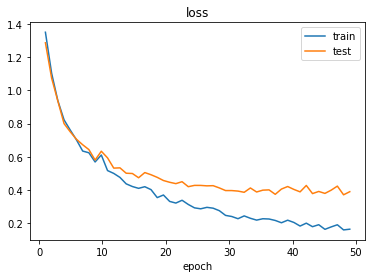

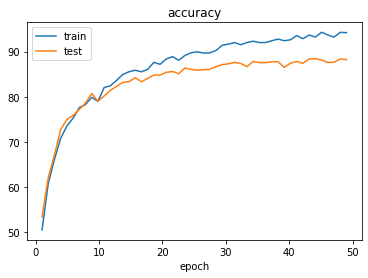

Train accuracy:  94.21
Test accuracy:  88.23


In [41]:
# plotting test/train loss
xrange = np.linspace(1,50,50,endpoint=False)
plt.title('loss')
plt.plot(xrange,train_losses), plt.plot(xrange,test_losses)
plt.legend(['train', 'test'])
plt.xlabel("epoch")
plt.show()

# plotting test/train accuracy
plt.title('accuracy')
plt.plot(xrange,train_accs), plt.plot(xrange,test_accs)
plt.legend(['train', 'test'])
plt.xlabel("epoch")
plt.show()
print("Train accuracy: ", train_accs[-1])
print("Test accuracy: ",test_accs[-1])

In [42]:
torch.save(AlexNet_model,'model.pt')

In [246]:
#Training Accuracy
correct= 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 train images: %0.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 train images: 94.09 %


In [247]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %0.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86.47 %
